# CS413 Image and Video Analysis -- Lab 9

## Department of Computer Science, University of Warwick
## November, 2019


## Aims:

The aims of this lab are to 

+ Learn how to implement a CNN using Keras
+ Explore variations of the convolution/max-pooling/dropout layer sandwiches
+ Learn about under and overfitting
+ Investigate the effects of numbers of epochs, batch size, learning rate and drop-out layers
+ Learn how to plot learning histories 
+ Evaluate and predict using a trained model and measure classification accuracy

## Working on Google CoLabs -- Accessing data

You will probably want to run this lab on GoogleCoLabs, in which case, to simplest way to access data 
is to attach your Google Drive directory to the Google CoLabs session by using the following code:

Note for this Lab you only need to have the COIL-100 data which can be directly accessed from here

http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip


~~~
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

# list the contents of your drive and the lab data directory
!ls /content/drive/My\ Drive/data

# then to say read an image called 'some-image.png' you need to do something like this 
data_dir = 'drive/My Drive/data/'
im = cv2.read(data_dir + 'some-image.png')
~~~

In [98]:
import os
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 # opencv


## COIL-100 data

Load up the COIL-100 data as we have done previously.

In [99]:
num_classes = 100

data_dir = '/modules/cs413/data/coil-100/' # or 'drive/My Drive/data/coil-100/' on Google Drive

images = []
classes = []
example_images = []
do_limit = False
max_per_class = 32
for i in range(num_classes):

    filenames = glob.glob(data_dir + 'obj' + str(i+1) + '_*.png')
    
    for j in range(len(filenames)):
        
        im_gbr = cv2.imread(filenames[j])
        im = cv2.cvtColor(im_gbr,cv2.COLOR_BGR2RGB) # convert from BGR ordering to RGB

        images.append(im)
        classes.append(i)

        if (j==0):
            example_images.append(im) # keep and example of each class
            
        # limit to 10 images per example
        if do_limit:
            if (j==9):
                break



## Keras imports

Import Keras model `Sequential` so we can `add` Keras layers. 

In this Lab we will just use the two layers:
~~~
    Conv2D  
    MaxPooling2D
    Dense
~~~

And the operations `Flatten` and `Dropout`.



In [100]:
import os

import keras
from keras.models import Sequential


from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop

## Exercise -- Data Wrangling

Start by wrangling the data so that it in two arrays `x` and `y` which contain the image data and the classes.

Normalise the image data to have range [0,1] and use `sklearn.utils.shuffle` to randomize the locations of the 
x-y pairs. 

Then make a training-validation split (e.g. 70% training, 30% validation) and put the subsets into two pairs 
of variables: `x_train, y_train` and 'x_val, y_val'.
    
Print out the shapes of these variables.

In [101]:
# convert data to numpy arrays and normalize
# x = ...
# y = ...

x = np.array(images).astype('float')/255.0
y = np.array(classes)

# shuffle the data
from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=0)
#x, y = shuffle(...)


print('x shape is ', x.shape)
print('y shape is ', y.shape)

# partition data
n70 = int(0.7 * x.shape[0])
n30 = x.shape[0] - n70

#x_train, x_val = 
#y_train, y_val = 

x_train, x_val = x[:n70], x[n70:]
y_train, y_val = y[:n70], y[n70:]


print('x_train shape is ', x_train.shape)
print('y_train shape is ', y_train.shape)

x shape is  (7200, 128, 128, 3)
y shape is  (7200,)
x_train shape is  (5040, 128, 128, 3)
y_train shape is  (5040,)


## Which backend have you got?

This isn't a personal question!

Depending on the *backend* kernel you have on your Keras installation, the order of the axes in the 
network input will need to be either channel-first or channel-last.

We will need to confirm whether the kernel needs channel-first or channel-last and re-order the
data variables by using `np.reshape` as appropriate.

Use this incantantion which will set up the shape (`input_shape`) of the input-layer.


In [102]:
from keras import backend as K

# input image dimensions
img_rows, img_cols, num_channels = images[0].shape

if K.image_data_format() == 'channels_first':
    print("first")
    x_train = x_train.reshape(x_train.shape[0], num_channels, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], num_channels, img_rows, img_cols)
    input_shape = (num_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, num_channels)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, num_channels)
    input_shape = (img_rows, img_cols, num_channels)
    
print('input_shape is ', input_shape)

input_shape is  (128, 128, 3)


## Exercise -- One-hot-coding

Convert your training and validation output vectors, i.e. `y_train` and `y_val` to one-hot-coded vectors
using `keras.utils.to_categorical()`.



In [103]:

# convert class vectors to binary class matrices
y_train_hot = keras.utils.to_categorical(y_train)
y_val_hot = keras.utils.to_categorical(y_val)

print('one hot coded', y_train_hot[0], ', class is ', np.argmax(y_train_hot[0]))

one hot coded [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] , class is  40


## Exercise -- Design Network

You are now ready to build your CNN.

Hint: Make a network with at least one convolution and one max-pooling and complete the network with
a dense layer with `num_classes` output neurons and a `softmax` activation. 

Start simple!

In [117]:

print('Input shape is ', input_shape)

print(num_classes)

batch_size = 1260 # you decide
epochs = 5 # you decide

model = Sequential()
model.add(Conv2D(32, 3, input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.build(x_train.shape)
model.summary()

Input shape is  (128, 128, 3)
100
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 14400)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               1440100   
Total params: 1,445,620
Trainable params: 1,445,620
Non-trainable params: 0
_________

## Exercise -- Training/Fitting

Compile your network using an appropriate optimizer (e.g. `keras.optimizers.Adam()`)
and use an appropriate `batch_size` and number of `epochs` to fit your
training data. 


In [118]:

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train_hot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val_hot))

model.summary()

Train on 5040 samples, validate on 2160 samples
Epoch 1/5
5040/5040 [==============================] - 17s 3ms/step - loss: 4.0667 - accuracy: 0.1774 - val_loss: 3.0022 - val_accuracy: 0.4806
Epoch 2/5
5040/5040 [==============================] - 17s 3ms/step - loss: 2.2542 - accuracy: 0.6351 - val_loss: 1.3336 - val_accuracy: 0.7653
Epoch 3/5
5040/5040 [==============================] - 17s 3ms/step - loss: 0.9490 - accuracy: 0.8365 - val_loss: 0.6552 - val_accuracy: 0.8509
Epoch 4/5
5040/5040 [==============================] - 17s 3ms/step - loss: 0.4367 - accuracy: 0.9060 - val_loss: 0.3446 - val_accuracy: 0.9231
Epoch 5/5
5040/5040 [==============================] - 17s 3ms/step - loss: 0.2290 - accuracy: 0.9520 - val_loss: 0.2300 - val_accuracy: 0.9384
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 126, 126, 32)      896       
___________

## Exercise -- Training and validation / Optimizing the design

Use the `history` returned from the `fit()` function above, 
plot loss/accurcay curves during training and validation.

1. Are you satisfied the network is training without overfitting?
2. Is the final accuracy good enough? 
3. Do you need to change the batch size or the number of epochs?
4. Try adding `Dropout` after each max-pooling layer, e.g. 
~~~~
    model.add(Dropout(0.25)) # you can vary the the rate of dropout, e.g. 25%
~~~~
5. Do you need to change the learning rate of the optimizer?
6. Do you need to modify the design of your network?



2160/2160 [==============================] - 2s 810us/step


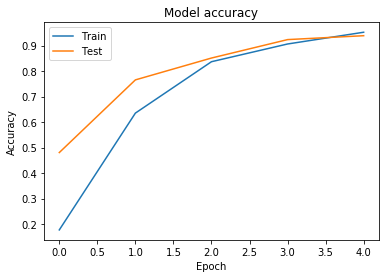

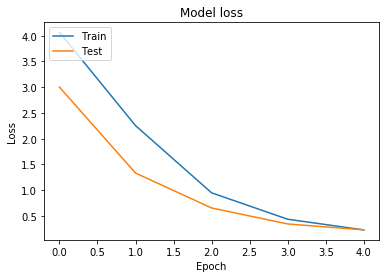

In [121]:
model.evaluate(x_val,y_val_hot)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Exercise -- Evaluate the accuracy of the model

Use the `model.evaluate()` function to find an accuracy score for the final model. 



## Exercise -- Confusion matrix

Use your model to predict the classes (`y_val_hat`) of the validation data (`x_val`) and 
calculate the entries of a confusion matrix over all the classes.

Print out the first 10 x 10 of this matrix.

Plot the matrix as an image.


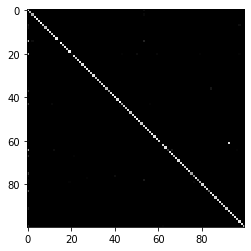

In [134]:
from sklearn import metrics
predictions = model.predict(x_train)
y_pred = (predictions > 0.5)

matrix = metrics.confusion_matrix(np.argmax(y_train_hot,axis=1), np.argmax(y_pred,axis=1))

plt.imshow(matrix,cmap="gray")
plt.show()

## Exercise -- Visualise K nearest-neighbour matches

Once you are satistfied with your classifier, use it visualise which are the nearest K images to a given query image.

Visualise also for any test image, which image not of that class, it matches with the highest accuracy (false-match).

Compare your results with the bag of visual words methods from Lab-8.


## Further Exercises


If you have got this far, then well done!

You should be now be in a good position to explore what you can do with CNNs using Keras.  

You might like to run your network on the CIFAR10 data set which is built-in 
(you will probably need to do this on Google CoLabs).

Look at a Keras example where they do transfer learning, perhaps using VGG16 as the pre-trained network.

Implement a VGG16 pretrained network for the COIL-100 data.
